#### Performing density matching using TT-parametrized ODE flows



In Chen et al. 2018, the concept of continuous normalizing flows is introduced. Normalizing flows rely on the change-of-variables theorem and its inherent ability to compute the exact change in probability density functions if random variables are transformed through a bijective function f via 
$$
y = f(x) \Rightarrow p_{Y}(y) = p_{X}(x) \left\vert \det\right(\frac{\partial f}{\partial x}\left) \right\vert^{-1}.
$$

Infinitesimal refinements from a concatenation of finitely many discrete layers to continuous transformations lead to continuous normalizing flows driven by ODE systems of the form 
$$
\dot{x}(t) = u(t, x(t)), \quad t \in [0, T], 
$$
where we suggest to parametrize the velocity field $u = u_\theta$ by a TT with cores indicated by $\theta$. 

In the following experiments, the TT-representation is expanded by incorporating a time-dependent core, which allows the system to dynamically adjust as time progresses, i.e.,
$$
u_\theta(t, x_1, \ldots, x_d) = \sum_{i_1=0}^{m} \cdots \sum_{i_d=0}^{m} 
\hat{U}(i_1, \cdot) \hat{U}(\cdot, i_2, \cdot) \cdots \hat{U}(\cdot, i_{d+1}, \cdot)
P_{i_1}(t) P_{i_2}(x_1) \cdots P_{i_{d+1}}(x_d), 
$$
with ranks $r_0 = 1, r_{d+1} = d, r_1 = \ldots, r_d = r$ for any a priori set $r \in \N$.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt
import os

from torchdiffeq import odeint
from itertools import cycle

from src.basis_functions import OrthonormalBasis, OrthonormalLegendre1D, BSpline1D, Fourier1D
from src.velocity_functions import Func, FuncTT
from src.ode_wrapper import ContinuousNormalizingFlowODE

from utils.trajectories import plot_trajectories_over_time, plot_vector_fields_at_times

# torch.manual_seed(42)
# np.random.seed(42)

##### Shifting standard Gaussian

Starting from a 2-dimensional standard Gaussian random variable $X$, we pursue learning a mapping $f_\theta: \R^2 \to \R^2$ that transforms $X$ into a shifted Gaussian $Z$ with mean $\mu_Z = (5, 5)$ via $f_\theta(\mathrm{x}) = x(T)$, where function $x$ solves the IVP 
$$
\dot{x}(t) = u_\theta(t, x(t)), \quad x(0) = \mathrm{x}, \quad t \in [0, T]. 
$$

This density matching task can be formulated w.r.t. the Kullback-Leibler divergence as a minimization problem of the form 
$$
\min_{\theta} \ \mathrm{KL}(p_{f_\theta(X)} \Vert p_Z),
$$
where the change-of-variables theorem allows to reformulate the loss function
$$
\begin{aligned}
\mathrm{KL}(p_{f_\theta(X)} \Vert p_Z) &= \int_{\R^2} \log \left(\frac{p_{f_\theta(X)}(z)}{p_Z(z)}\right)p_{f_\theta(X)}(z) dz\\
&= \int_{\R^2} \log \left(\frac{p_{f_\theta(X)}(f_{\theta}(x))}{p_Z(f(x))}\right)p_{f_\theta(X)}(f_{\theta}(x)) \vert \det(\nabla f(x)) \vert dx\\
&= \int_{\R^2} \log \left(\frac{p_X(x)}{p_Z(f_{\theta}(x))\vert \det(\nabla f_{\theta}(x)) \vert}\right)p_X(x) dx\\
&= \int_{\R^2} \left( \log(p_X(x)) - \log(p_Z(f_{\theta}(x))) - \log(\vert \det(\nabla f_{\theta}(x)) \vert) \right) p_X(x) dx\\
&= \int_{\R^2} \left( \log(p_X(x)) \underbrace{- \log (\vert \det(\nabla f_{\theta}(x)) \vert) + \frac{1}{2} \Vert f_\theta(x) - \mu_Z \Vert^2 + \log(2\pi)}_{=: C(x, T)} \right) p_X(x) dx\\
&= \mathbb{E}_{p_X \sim x}\left[ \log(p_X(x)) + C(x, T) \right].
\end{aligned}
$$

Incorporating the $L^2$-transport cost, see Onken et al. 2020,
$$
L(x, T) = \int_0^T \frac{1}{2} \Vert u_\theta(t, x(t)) \Vert dt,
$$
and neglecting terms not depending on $\theta$, we obtain the regularized minimization problem 
$$
\min_{\theta} \mathbb{E}_{p_X \sim x}\left[ C(x, T) + L(x, T) \right],
$$
subject to the dynamical system driving the trajectories that induce our mapping $f_\theta: \R^2 \to \R^2$. Here, the transport cost penalizes the arc-length of the trajectories. The integral can be computed in the ODE solver.

Further, according to Chen et al. 2018, the instantaneous change of variables formula leads to an efficient approach to calculate the cost term $\log (\vert \det(\nabla f_{\theta}(x)) \vert)$ via the extended system of ODEs
$$
\begin{aligned}
\frac{d}{dt}x(t) &= u_\theta(t, x(t)),\\
\frac{d}{dt}\ell(t) &= \text{tr}(\nabla u_\theta(t, x(t))),
\end{aligned}
$$
$t \in [0, T]$, with $x(0) = \mathrm{x}$, $\ell(0) = 0$, where the first component maps a point $\mathrm{x}$ to $f_\theta(\mathrm{x}) = x(T)$ by following the trajectory 
$$
x: [0, T] \to \R^2
$$
and the final state of the second component satisfies $\ell(T) = \log (\vert \det(\nabla f_{\theta}(x)) \vert)$. This allows a reformulation of the cost function into
$$
C(x, T) = \frac{1}{2} \Vert f_\theta(x) - \mu_Z \Vert_2^2 - \ell(T) + \log(2\pi).
$$

In [2]:
# Generate 2D sample data from (scaled) standard Gaussian
def generate_data(mean, cov, n_samples):
    # Create a multivariate normal distribution and sample
    x = torch.distributions.MultivariateNormal(mean, cov).sample((n_samples,))
    return x

1. **Legendre basis:**

    Begin the experiment by employing a FTT representation of the time-dependent right-hand side of the ODE, constructed using a **Legendre polynomial basis of dimension 4**. The experiment is conducted for **FTTs of ranks 4, 8, 16**. 

In [3]:
# Configure a Legendre basis for the FTT on the right-hand side of the ODE
dimension = 4
d = 3

bases = [
        OrthonormalLegendre1D(torch.eye(dimension, dtype=float), domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 4


In [4]:
# Training parameters
n_samples = 256
n_epochs = 30
batch_size = 64
learning_rate = 1e-3

In [16]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)
mean = torch.zeros(2)
cov = 1e-1 * torch.eye(2)
data = generate_data(mean, cov, n_samples)

# Initialize FTTs of rank 4, 8, 16
ftt_rank4 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=2, d_out=2, bases=bases, rank=8, time_dependent=True)
ftt_rank16 = FuncTT(d_in=2, d_out=2, bases=bases, rank=16, time_dependent=True)

model_rank4 = ContinuousNormalizingFlowODE(ftt_rank4)
model_rank8 = ContinuousNormalizingFlowODE(ftt_rank8)
model_rank16 = ContinuousNormalizingFlowODE(ftt_rank16)

# Set the models to training mode and choose optimizer
model_rank4.train()
model_rank8.train()
model_rank16.train()

optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)
optimizer_rank16 = optim.AdamW(model_rank16.parameters(), lr=learning_rate)

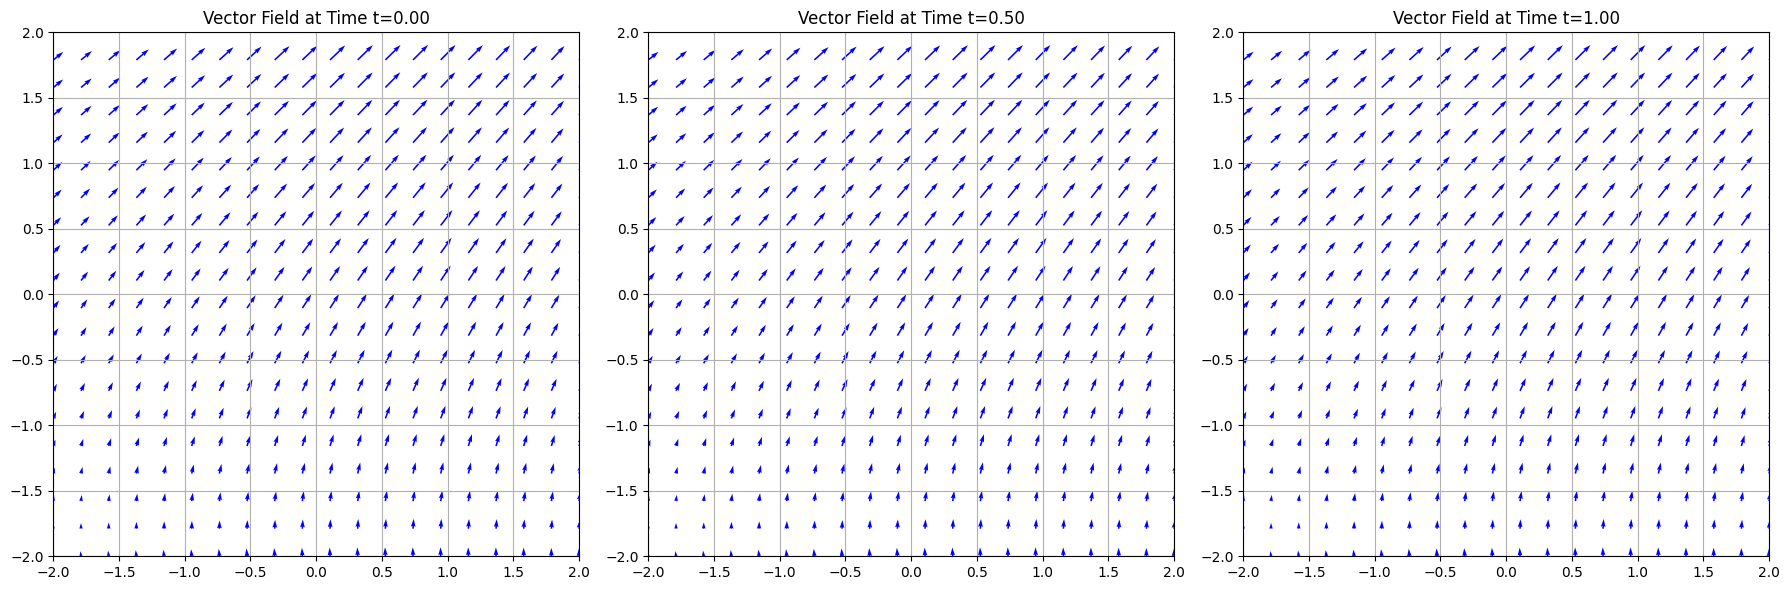

In [35]:
# Plot ODE flow vector field in various points over time after training
plot_vector_fields_at_times(model_rank4.func, x_range = (-2., 2.), y_range = (-2., 2.), plot_time = torch.tensor([0.0, 0.5, 1.0]))


In [26]:
# Loss function incorporating Kullback-Leibler-Divergenz
def loss_func(model, x: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str, backward: bool, 
              lambda_transport_reg, lambda_tt_reg):

    y_pred = model(x, ts, rtol, atol, method, backward)

    l2_transport_cost = model.transport_cost
    log_det_gradient_func = model.trace_integral

    tt_regularization = sum(torch.norm(core, p="fro") for core in model.func.tt_cores)
    
    target_mean = torch.tensor([2.0, 2.0], device=x.device, requires_grad=False).expand_as(y_pred)
    kl_divergence = 0.5 * ((y_pred - target_mean) ** 2).sum(dim=1) - log_det_gradient_func + lambda_transport_reg * l2_transport_cost
    return kl_divergence.mean() + lambda_tt_reg * tt_regularization

In [27]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [28]:
training_dict = {}
training_procedure(model_rank4, data, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")
training_procedure(model_rank16, data, batch_size, n_epochs, optimizer_rank16, training_dict, "Rank 16")


Training Run ID: Rank 4

Epoch [1/30], Loss: 4.1510, Transport Cost: 0.0002
Epoch [2/30], Loss: 4.1424, Transport Cost: 0.0002
Epoch [3/30], Loss: 4.1344, Transport Cost: 0.0002
Epoch [4/30], Loss: 4.1262, Transport Cost: 0.0003
Epoch [5/30], Loss: 4.1170, Transport Cost: 0.0004
Epoch [6/30], Loss: 4.1069, Transport Cost: 0.0006
Epoch [7/30], Loss: 4.0943, Transport Cost: 0.0008
Epoch [8/30], Loss: 4.0795, Transport Cost: 0.0012
Epoch [9/30], Loss: 4.0613, Transport Cost: 0.0016
Epoch [10/30], Loss: 4.0394, Transport Cost: 0.0022
Epoch [11/30], Loss: 4.0131, Transport Cost: 0.0031
Epoch [12/30], Loss: 3.9806, Transport Cost: 0.0047
Epoch [13/30], Loss: 3.9421, Transport Cost: 0.0066
Epoch [14/30], Loss: 3.8964, Transport Cost: 0.0089
Epoch [15/30], Loss: 3.8408, Transport Cost: 0.0128
Epoch [16/30], Loss: 3.7754, Transport Cost: 0.0181
Epoch [17/30], Loss: 3.6983, Transport Cost: 0.0250
Epoch [18/30], Loss: 3.6079, Transport Cost: 0.0343
Epoch [19/30], Loss: 3.5021, Transport Cost: 0.

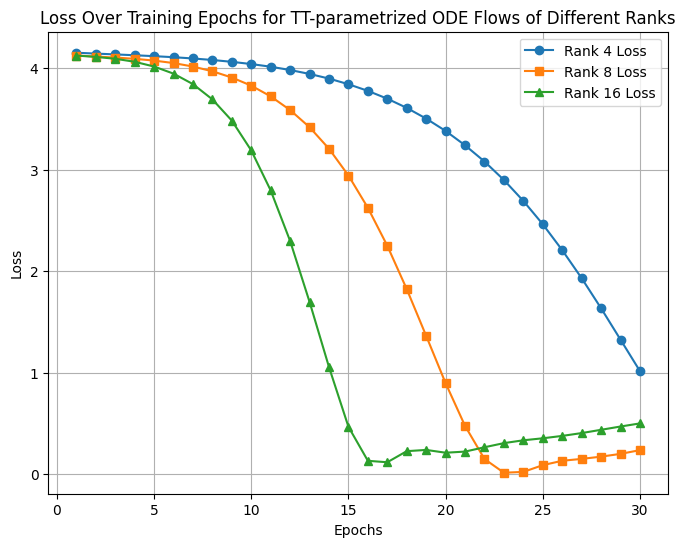

In [30]:
# Number of epochs
n_epochs = len(training_dict["Rank 4"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='o', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='s', label='Rank 8 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 16"], marker='^', label='Rank 16 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_shifting_gaussian_training_loss_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

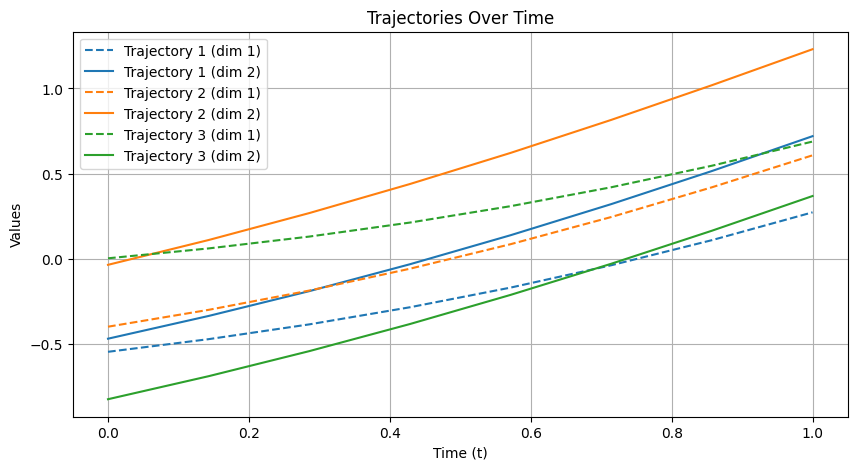

In [31]:
# Plot ODE flow trajectories over time after training
initial_points = torch.rand(3, 2) * 2 - 1
plot_trajectories_over_time(model_rank4.func, initial_points, ts = torch.tensor(np.linspace(0., 1., 8)))

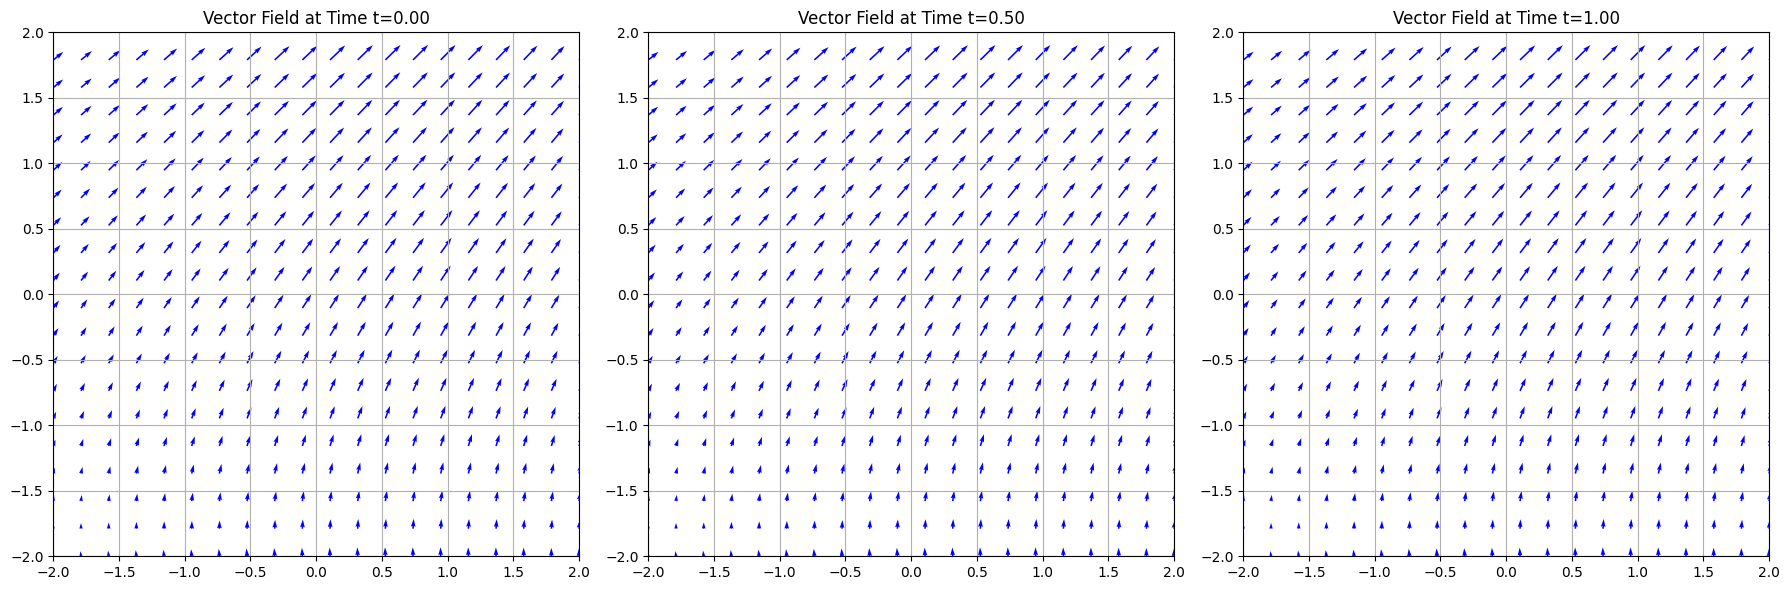

In [32]:
# Plot ODE flow vector field in various points over time after training
plot_vector_fields_at_times(model_rank4.func, x_range = (-2., 2.), y_range = (-2., 2.), plot_time = torch.tensor([0.0, 0.5, 1.0]))

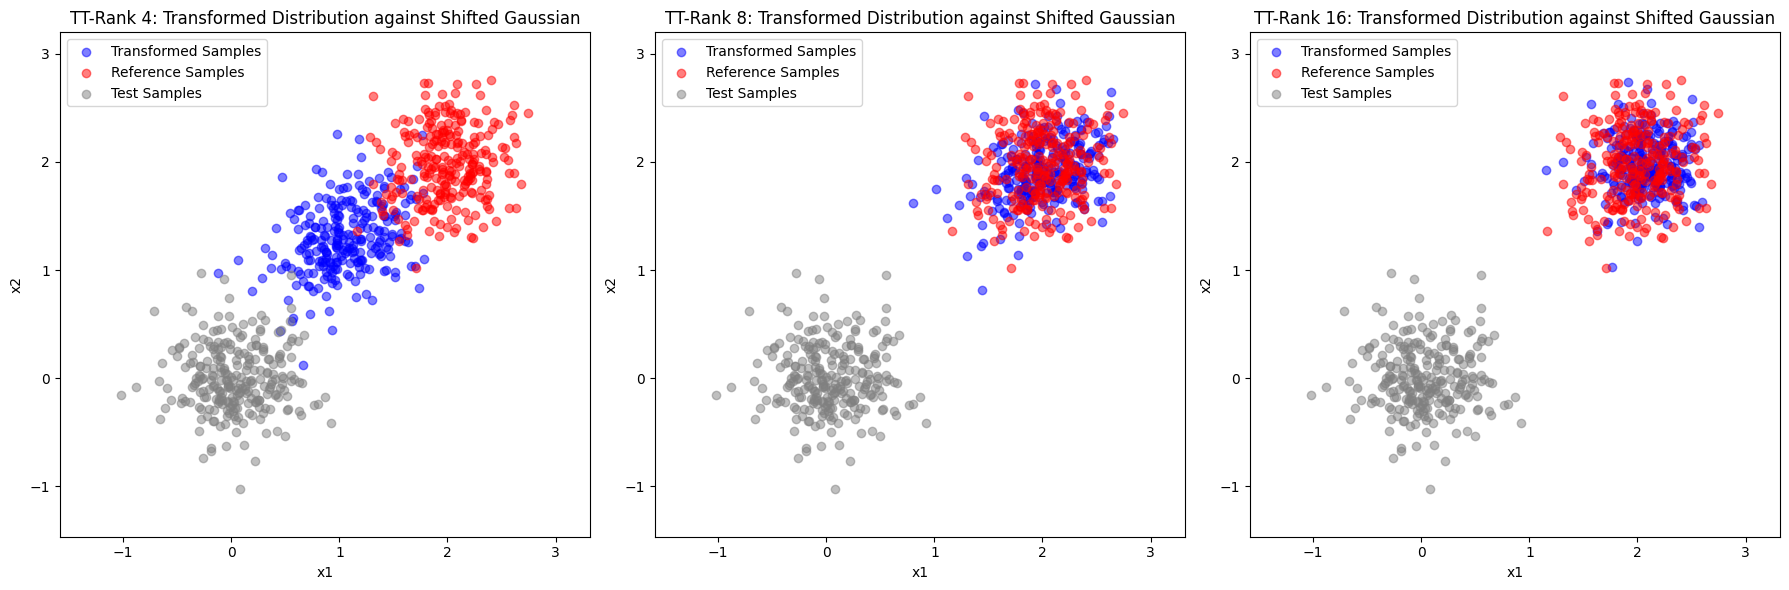

In [36]:
# Sample from standard Gaussian
mean = torch.tensor([0., 0.])
cov = 1e-1 * torch.eye(2)

x_samples = generate_data(mean, cov, n_samples)

# Sample from the Shifted Gaussian
shifted_mean = torch.tensor([2.0, 2.0])    

y_target = generate_data(shifted_mean, cov, n_samples)

# List of models and corresponding ranks
models = [model_rank4, model_rank8, model_rank16]
ranks = [4, 8, 16]

# Create figure for subplots
plt.figure(figsize=(18, 6))

# Loop over the models
for i, (model, rank) in enumerate(zip(models, ranks)):
    # Transform samples through the current flow model
    y_pred = model(x_samples, ts = torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3, atol=1e-6, method='euler', backward=False)
    
    # Create a subplot for each model
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_pred[:, 0].detach().numpy(), y_pred[:, 1].detach().numpy(), color='blue', alpha=0.5, label="Transformed Samples")
    plt.scatter(y_target[:, 0].detach().numpy(), y_target[:, 1].detach().numpy(), color='red', alpha=0.5, label="Reference Samples")
    plt.scatter(x_samples[:, 0].detach().numpy(), x_samples[:, 1].detach().numpy(), color='grey', alpha=0.5, label="Test Samples")
    plt.title(f"TT-Rank {rank}: Transformed Distribution against Shifted Gaussian")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.axis('equal')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_shifting_gaussian_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

##### Matching a standard Gaussian with a Gaussian Mixture Model of 2 modes

In [51]:
# Function to sample from the GMM with 2 modes
def sample_gmm(weights, component1, component2, n_samples):
    component_indices = torch.multinomial(weights, n_samples, replacement=True)
    samples = []
    for i in range(n_samples):
        if component_indices[i] == 0:
            samples.append(component1.sample())
        else:
            samples.append(component2.sample())
    return torch.stack(samples)

1. **Legendre basis:**

    Begin the experiment by employing a FTT representation of the time-dependent right-hand side of the ODE, constructed using a **Legendre polynomial basis of dimension 8**. The experiment is conducted for **FTTs of ranks 4, 8, 16**. 

In [43]:
# Configure a Legendre basis for the FTT on the right-hand side of the ODE
dimension = 16
d = 3

bases = [
        OrthonormalLegendre1D(torch.eye(dimension, dtype=float), domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 16


In [44]:
# Training parameters
n_samples = 256
n_epochs = 50
batch_size = 64
learning_rate = 1e-3

In [45]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)
mean = torch.zeros(2)
cov = 1e-1 * torch.eye(2)
data = generate_data(mean, cov, n_samples)

# Initialize FTTs of rank 4, 8, 16
ftt_rank4 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=2, d_out=2, bases=bases, rank=8, time_dependent=True)
ftt_rank16 = FuncTT(d_in=2, d_out=2, bases=bases, rank=16, time_dependent=True)

model_rank4 = ContinuousNormalizingFlowODE(ftt_rank4)
model_rank8 = ContinuousNormalizingFlowODE(ftt_rank8)
model_rank16 = ContinuousNormalizingFlowODE(ftt_rank16)

# Set the models to training mode and choose optimizer
model_rank4.train()
model_rank8.train()
model_rank16.train()

optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)
optimizer_rank16 = optim.AdamW(model_rank16.parameters(), lr=learning_rate)

In [46]:
# Loss function incorporating Kullback-Leibler-Divergenz
def loss_func(model, x: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str, backward: bool, 
              lambda_transport_reg, lambda_tt_reg):

    y_pred = model(x, ts, rtol, atol, method, backward)

    l2_transport_cost = model.transport_cost
    log_det_gradient_func = model.trace_integral
    
    tt_regularization = sum(torch.norm(core, p="fro") for core in model.func.tt_cores)

    target_means = [torch.tensor([-2.0, -2.0], device=x.device, requires_grad=False).expand_as(y_pred),
        torch.tensor([2.0, 2.0], device=x.device, requires_grad=False).expand_as(y_pred)
    ]
    
    K = len(target_means) # Number of components
    gmm_term = torch.zeros(y_pred.shape[0])
    for comp in range(K):
        gmm_term += (1 / (4 * torch.tensor(math.pi))) * torch.exp(-0.5 * ((y_pred - target_means[comp]) ** 2).sum(dim=1))
    kl_divergence = -torch.log(gmm_term + 1e-6) - log_det_gradient_func + lambda_transport_reg * l2_transport_cost
    return kl_divergence.mean() + lambda_tt_reg * tt_regularization

In [47]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [48]:
training_dict = {}
training_procedure(model_rank4, data, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")
training_procedure(model_rank16, data, batch_size, n_epochs, optimizer_rank16, training_dict, "Rank 16")


Training Run ID: Rank 4

Epoch [1/50], Loss: 5.6442, Transport Cost: 0.0001
Epoch [2/50], Loss: 5.6312, Transport Cost: 0.0002
Epoch [3/50], Loss: 5.6046, Transport Cost: 0.0007
Epoch [4/50], Loss: 5.5466, Transport Cost: 0.0021
Epoch [5/50], Loss: 5.4369, Transport Cost: 0.0070
Epoch [6/50], Loss: 5.2408, Transport Cost: 0.0190
Epoch [7/50], Loss: 4.9543, Transport Cost: 0.0594
Epoch [8/50], Loss: 4.6019, Transport Cost: 0.1352
Epoch [9/50], Loss: 4.3107, Transport Cost: 0.3093
Epoch [10/50], Loss: 4.2367, Transport Cost: 0.5629
Epoch [11/50], Loss: 4.4075, Transport Cost: 0.8449
Epoch [12/50], Loss: 4.6343, Transport Cost: 1.0738
Epoch [13/50], Loss: 4.8231, Transport Cost: 1.3418
Epoch [14/50], Loss: 4.8788, Transport Cost: 1.6211
Epoch [15/50], Loss: 4.8855, Transport Cost: 1.9253
Epoch [16/50], Loss: 4.7998, Transport Cost: 2.1956
Epoch [17/50], Loss: 4.6204, Transport Cost: 2.3700
Epoch [18/50], Loss: 4.4093, Transport Cost: 2.7633
Epoch [19/50], Loss: 4.2138, Transport Cost: 2.

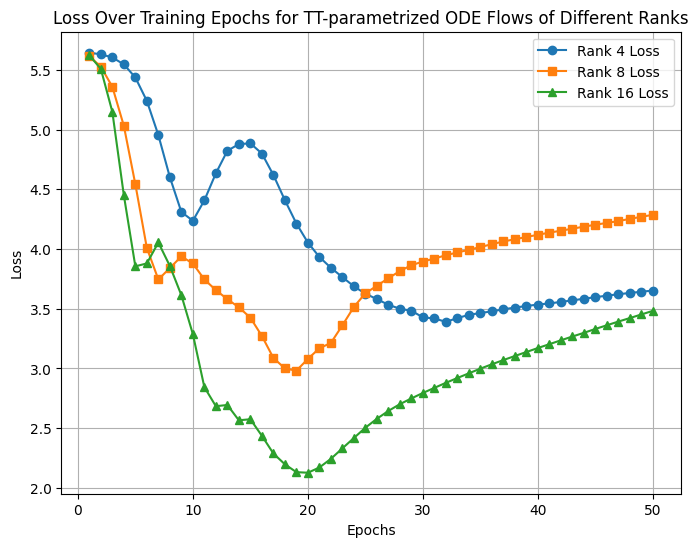

In [49]:
# Number of epochs
n_epochs = len(training_dict["Rank 4"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='o', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='s', label='Rank 8 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 16"], marker='^', label='Rank 16 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_matching_gmm2_training_loss_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

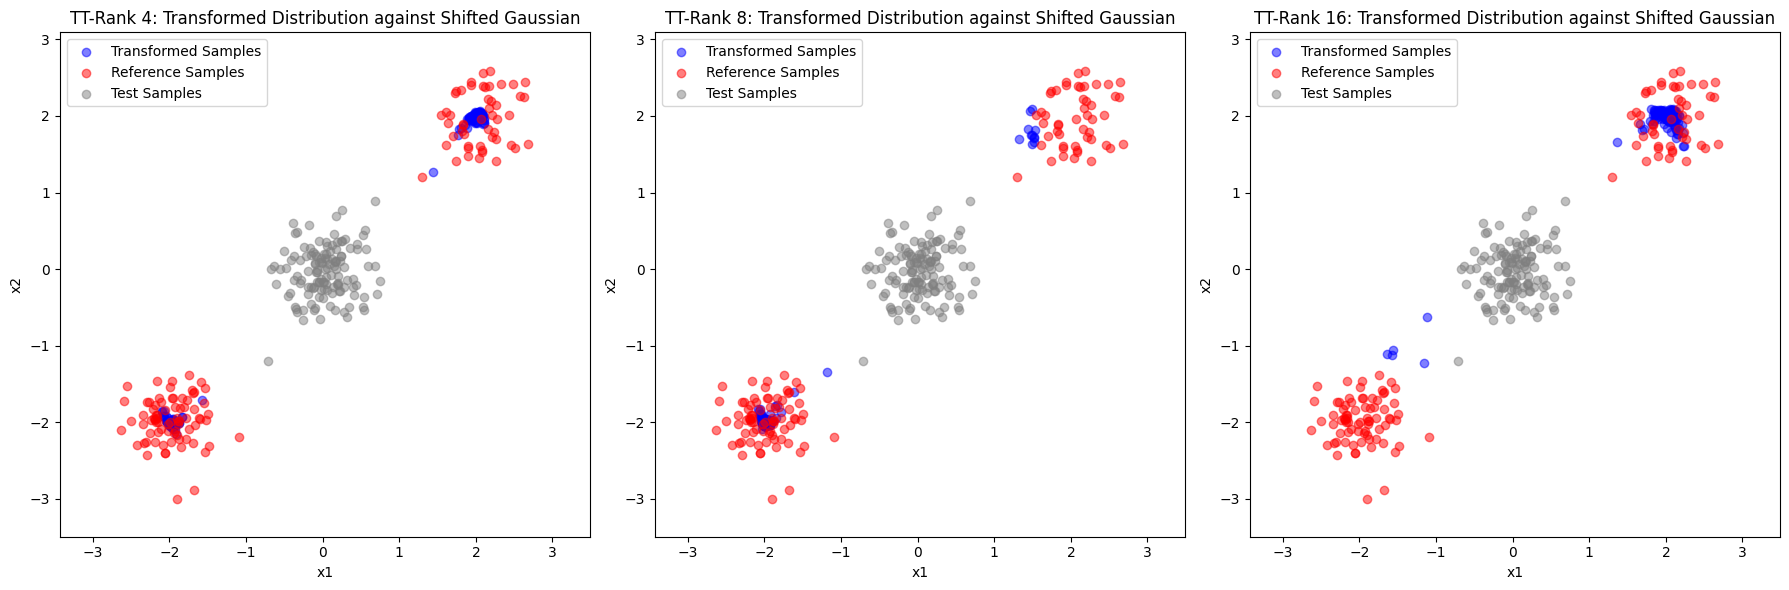

In [54]:
n_samples = 128
# Sample from standard Gaussian
mean = torch.tensor([0., 0.])
cov = 1e-1 * torch.eye(2)

x_samples = generate_data(mean, cov, n_samples)

# Sample from the GMM with 2 modes
weights = torch.tensor([0.5, 0.5])
mean1 = torch.tensor([-2.0, -2.0])  
mean2 = torch.tensor([2.0, 2.0])    
covariance_matrix = 1e-1 * torch.eye(2)

component1 = torch.distributions.MultivariateNormal(mean1, covariance_matrix)
component2 = torch.distributions.MultivariateNormal(mean2, covariance_matrix)

y_target = sample_gmm(weights, component1, component2, n_samples)

# List of models and corresponding ranks
models = [model_rank4, model_rank8, model_rank16]
ranks = [4, 8, 16]

# Create figure for subplots
plt.figure(figsize=(18, 6))

# Loop over the models
for i, (model, rank) in enumerate(zip(models, ranks)):
    # Transform samples through the current flow model
    y_pred = model(x_samples, ts = torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3, atol=1e-6, method='euler', backward=False)
    
    # Create a subplot for each model
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_pred[:, 0].detach().numpy(), y_pred[:, 1].detach().numpy(), color='blue', alpha=0.5, label="Transformed Samples")
    plt.scatter(y_target[:, 0].detach().numpy(), y_target[:, 1].detach().numpy(), color='red', alpha=0.5, label="Reference Samples")
    plt.scatter(x_samples[:, 0].detach().numpy(), x_samples[:, 1].detach().numpy(), color='grey', alpha=0.5, label="Test Samples")
    plt.title(f"TT-Rank {rank}: Transformed Distribution against GMM with 4 Modes")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.axis('equal')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_matching_gmm2_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

##### Matching a standard Gaussian with a Gaussian Mixture Model of 4 modes

In [22]:
# Function to sample from the GMM with 4 modes
def sample_gmm(weights, components, n_samples):
    component_indices = torch.multinomial(weights, n_samples, replacement=True)
    samples = []
    for i in range(n_samples):
        component = components[component_indices[i]]
        samples.append(component.sample())
    return torch.stack(samples)


1. **Legendre basis:**

    Begin the experiment by employing a FTT representation of the time-dependent right-hand side of the ODE, constructed using a **Legendre polynomial basis of dimension 8**. The experiment is conducted for **FTTs of ranks 4, 8, 16**. 

In [32]:
# Configure a Legendre basis for the FTT on the right-hand side of the ODE
dimension = 16
d = 3

bases = [
        OrthonormalLegendre1D(torch.eye(dimension, dtype=float), domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 16


In [33]:
# Training parameters
n_samples = 256
n_epochs = 20
batch_size = 64
learning_rate = 1e-3

In [34]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)
mean = torch.zeros(2)
cov = 1e-1 * torch.eye(2)
data = generate_data(mean, cov, n_samples)

# Initialize FTTs of rank 4, 8, 16
ftt_rank4 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=2, d_out=2, bases=bases, rank=8, time_dependent=True)
ftt_rank16 = FuncTT(d_in=2, d_out=2, bases=bases, rank=16, time_dependent=True)

model_rank4 = ContinuousNormalizingFlowODE(ftt_rank4)
model_rank8 = ContinuousNormalizingFlowODE(ftt_rank8)
model_rank16 = ContinuousNormalizingFlowODE(ftt_rank16)

# Set the models to training mode and choose optimizer
model_rank4.train()
model_rank8.train()
model_rank16.train()

optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)
optimizer_rank16 = optim.AdamW(model_rank16.parameters(), lr=learning_rate)

In [35]:
# Loss function incorporating Kullback-Leibler-Divergenz
def loss_func(model, x: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str, backward: bool, 
              lambda_transport_reg, lambda_tt_reg):

    y_pred = model(x, ts, rtol, atol, method, backward)

    l2_transport_cost = model.transport_cost
    log_det_gradient_func = model.trace_integral
    
    tt_regularization = sum(torch.norm(core, p="fro") for core in model.func.tt_cores)

    target_means = [torch.tensor([-2.0, -2.0], device=x.device, requires_grad=False).expand_as(y_pred),
                    torch.tensor([2.0, 2.0], device=x.device, requires_grad=False).expand_as(y_pred),
                    torch.tensor([-2.0, 2.0], device=x.device, requires_grad=False).expand_as(y_pred), 
                    torch.tensor([2.0, -2.0], device=x.device, requires_grad=False).expand_as(y_pred)
    ]
    
    K = len(target_means) # Number of components
    gmm_term = torch.zeros(y_pred.shape[0])
    for comp in range(K):
        gmm_term += (1 / (8 * torch.tensor(math.pi))) * torch.exp(-0.5 * ((y_pred - target_means[comp]) ** 2).sum(dim=1))
    kl_divergence = -torch.log(gmm_term + 1e-6) - log_det_gradient_func + lambda_transport_reg * l2_transport_cost
    return kl_divergence.mean() + lambda_tt_reg * tt_regularization

In [36]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        
        # Reduce lambda_tt_reg
        lambda_transport_reg *= 1 / (10 ** (1/5))
        lambda_tt_reg *= 1 / (10 ** (1/5))

        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [37]:
training_dict = {}
training_procedure(model_rank4, data, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")
training_procedure(model_rank16, data, batch_size, n_epochs, optimizer_rank16, training_dict, "Rank 16")


Training Run ID: Rank 4

Epoch [1/20], Loss: 5.5719, Transport Cost: 0.0001
Epoch [2/20], Loss: 5.5315, Transport Cost: 0.0002
Epoch [3/20], Loss: 5.4729, Transport Cost: 0.0008
Epoch [4/20], Loss: 5.3766, Transport Cost: 0.0025
Epoch [5/20], Loss: 5.2270, Transport Cost: 0.0079
Epoch [6/20], Loss: 5.0053, Transport Cost: 0.0182
Epoch [7/20], Loss: 4.7078, Transport Cost: 0.0500
Epoch [8/20], Loss: 4.3655, Transport Cost: 0.1285
Epoch [9/20], Loss: 4.0444, Transport Cost: 0.2739
Epoch [10/20], Loss: 3.9022, Transport Cost: 0.5260
Epoch [11/20], Loss: 3.9340, Transport Cost: 0.8917
Epoch [12/20], Loss: 4.1029, Transport Cost: 1.2115
Epoch [13/20], Loss: 4.2393, Transport Cost: 1.5615
Epoch [14/20], Loss: 4.2862, Transport Cost: 1.9971
Epoch [15/20], Loss: 4.2684, Transport Cost: 2.7488
Epoch [16/20], Loss: 4.2827, Transport Cost: 2.9345
Epoch [17/20], Loss: 4.4096, Transport Cost: 3.7829
Epoch [18/20], Loss: 4.4944, Transport Cost: 4.1450
Epoch [19/20], Loss: 4.5534, Transport Cost: 4.

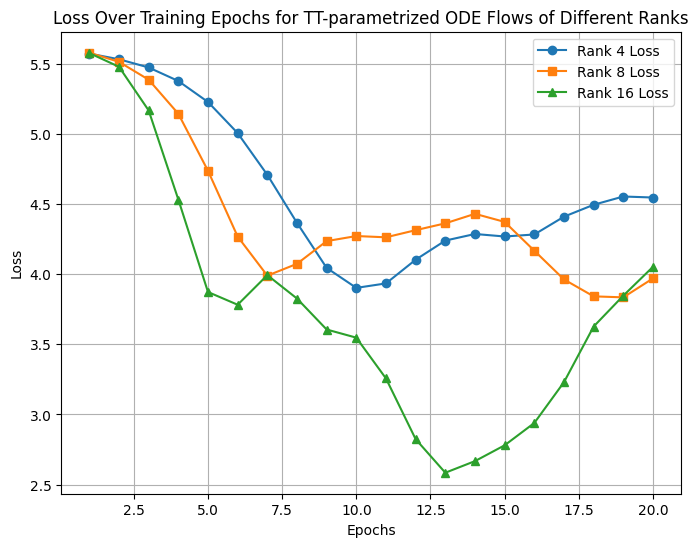

In [38]:
# Number of epochs
n_epochs = len(training_dict["Rank 4"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='o', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='s', label='Rank 8 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 16"], marker='^', label='Rank 16 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_matching_gmm4_training_loss_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

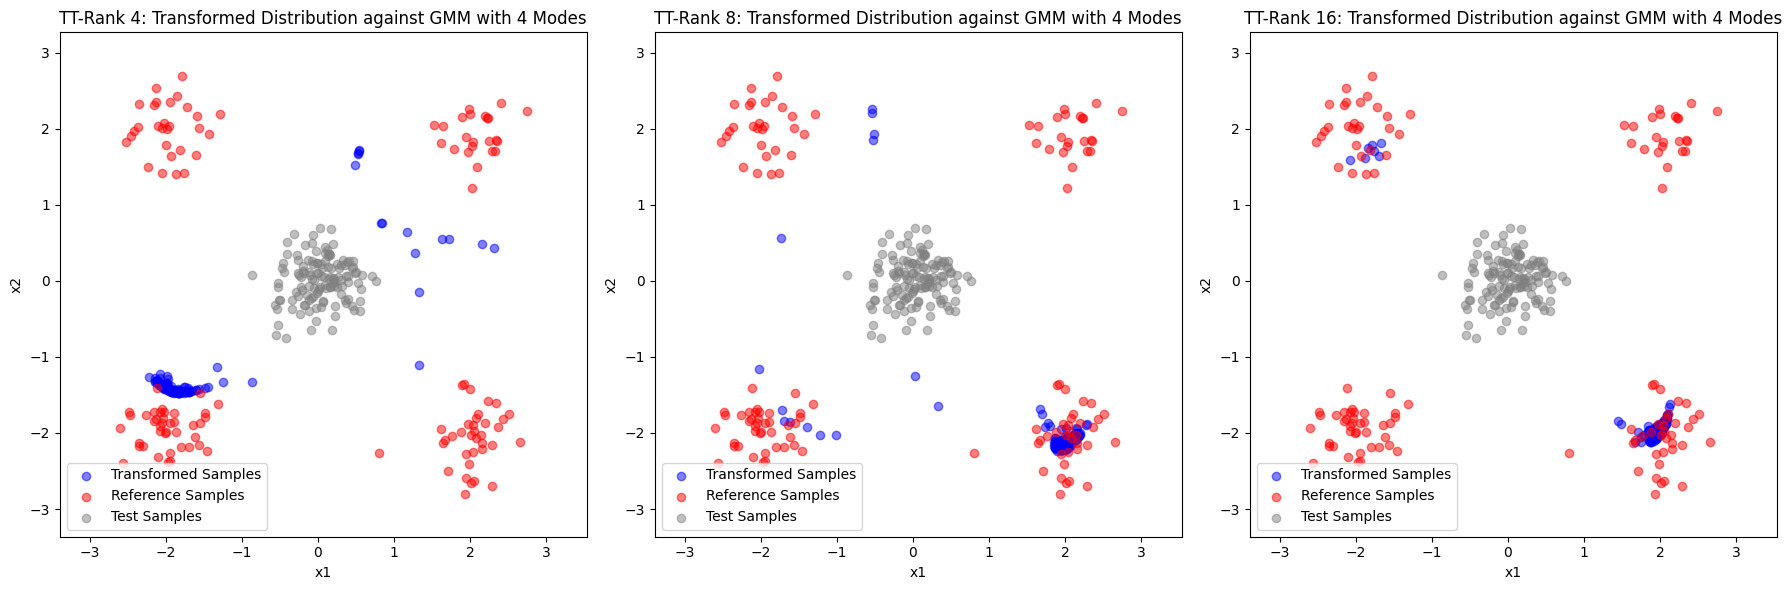

In [39]:
n_samples = 128
# Sample from standard Gaussian
mean = torch.tensor([0., 0.])
cov = 1e-1 * torch.eye(2)

x_samples = generate_data(mean, cov, n_samples)

# Sample from the GMM with 2 modes
weights = torch.tensor([0.25, 0.25, 0.25, 0.25,])
mean1 = torch.tensor([-2.0, -2.0])  
mean2 = torch.tensor([2.0, 2.0])
mean3 = torch.tensor([-2.0, 2.0])  
mean4 = torch.tensor([2.0, -2.0])  

component1 = torch.distributions.MultivariateNormal(mean1, cov)
component2 = torch.distributions.MultivariateNormal(mean2, cov)
component3 = torch.distributions.MultivariateNormal(mean3, cov)
component4 = torch.distributions.MultivariateNormal(mean4, cov)

components = [component1, component2, component3, component4]

y_target = sample_gmm(weights, components, n_samples)

# List of models and corresponding ranks
models = [model_rank4, model_rank8, model_rank16]
ranks = [4, 8, 16]

# Create figure for subplots
plt.figure(figsize=(18, 6))

# Loop over the models
for i, (model, rank) in enumerate(zip(models, ranks)):
    # Transform samples through the current flow model
    y_pred = model(x_samples, ts = torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3, atol=1e-6, method='euler', backward=False)
    
    # Create a subplot for each model
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_pred[:, 0].detach().numpy(), y_pred[:, 1].detach().numpy(), color='blue', alpha=0.5, label="Transformed Samples")
    plt.scatter(y_target[:, 0].detach().numpy(), y_target[:, 1].detach().numpy(), color='red', alpha=0.5, label="Reference Samples")
    plt.scatter(x_samples[:, 0].detach().numpy(), x_samples[:, 1].detach().numpy(), color='grey', alpha=0.5, label="Test Samples")
    plt.title(f"TT-Rank {rank}: Transformed Distribution against GMM with 4 Modes")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.axis('equal')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_matching_gmm4_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()